In [1]:
from PORTAL import PORTAL
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr, t
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp
from gsea_plots import dotplot, custom_gseaplot
from fast_mwu_analysis import run_mwu_analysis
from adjustText import adjust_text
import mygene

In [2]:
sns.set_context('paper')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14

In [3]:
umi_filepath = "/data1/normantm/angel/Pscreen_data/1st_screen_essentials/new/UMI_combined.csv"
TelN_rep_filepath = "/data1/normantm/angel/Pscreen_data/1st_screen_essentials/original_TelN_representations1.csv"
genomewide_perturbseq_path = '/data1/normantm/angel/genomewide_perturbseq/K562_essential_mean_pop_01_clean.hdf'

In [4]:
screen = PORTAL.from_csv(umi_filepath, input_rep_data=TelN_rep_filepath, rep_guide_columns=["guide_identity"],
                          sample_columns=["rep"])
screen.run_standard_analysis()

Generated guide IDs: 2390 genes with 9355 guides
Step 1/7: Filtering overrepresented lineages...
Applied thresholds: repr1=0.0500, repr2=0.0500
Step 2/7: Setting controls...
Step 3/7: Log transforming UMIs...
Step 4/7: Formatting sample columns...
Step 5/7: Regressing reporter...
Coefficients: [[ 0.29501498 -0.13819138  0.13819138]]
Intercept: [2.3777545]
R^2 score: 0.3814834627492102
Step 6/7: Regressing identity (Poisson)...
Step 7/7: Calculating summary statistics...

Analysis complete!
Summary: 9354 guides
  Controls: 100
  Targeting: 9254


In [5]:
# mapping ensembl id to gene name
screen.umi_df["ensembl"] = screen.umi_df.guide_identity.str.split("_").str[0]

mg = mygene.MyGeneInfo()
map_ensembl_symbol = mg.querymany(screen.umi_df.ensembl.unique(),
                                  scopes='ensembl.gene',
                                  fields="symbol",
                                  species='human',
                                  as_dataframe=True)[["symbol"]]
map_ensembl_symbol = map_ensembl_symbol['symbol'].fillna(map_ensembl_symbol.index.to_series())
map_ensembl_symbol["ENSG00000256618"] = "MTRNR2L1"
map_ensembl_symbol["ENSG00000112096"] = "SOD2"
map_ensembl_symbol["ENSG00000203812"] = "H2AC18"

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2390...done.
Finished.
4 input query terms found no hit:
	['ENSG00000256618', 'ENSG00000112096', 'non-targeting', 'ENSG00000203812']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


### Data processing visualizations

Text(55.95031565656568, 0.5, 'Reporter UMI counts')

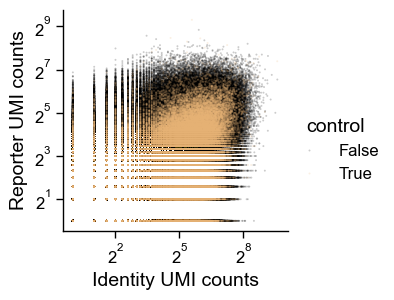

In [6]:
fig = sns.relplot(screen.filtered_umi_df.sort_values("control"), x="UMI_identity", y="UMI_reporter", hue="control",
            palette=['#010101', '#EAB679'],
            s=2, linewidth=0, alpha=0.2, height=3, aspect=1.1, rasterized=True)
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.xlabel("Identity UMI counts")
plt.ylabel("Reporter UMI counts")
# fig.savefig("initial_screen_reporter_identity_scatterplot.svg", bbox_inches="tight")

Text(52.10013888888888, 0.5, 'Reporter residuals')

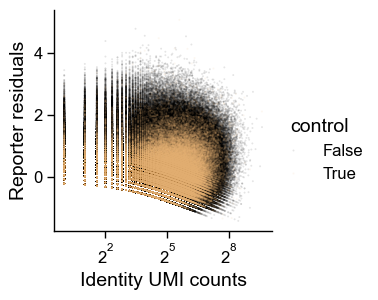

In [7]:
fig = sns.relplot(screen.filtered_umi_df.sort_values("control"), x="UMI_identity", y="reporter_resid", hue="control",
            palette=['#010101', '#EAB679'],
            s=2, linewidth=0, alpha=0.1, height=3, aspect=1, rasterized=True)
plt.xscale("log", base=2)
# plt.yscale("log", base=2)
plt.xlabel("Identity UMI counts")
plt.ylabel("Reporter residuals")
# fig.savefig("initial_screen_reporter_residual_identity_scatterplot.svg", bbox_inches="tight")

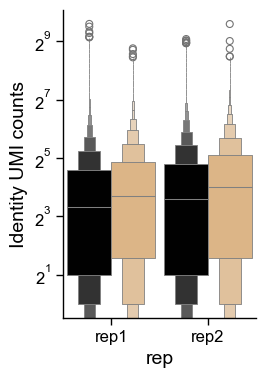

In [8]:
fig, ax = plt.subplots(figsize=(2.5,4))
sns.boxenplot(data=screen.filtered_umi_df, y="UMI_identity", x="rep", hue="control", palette=['#010101', '#EAB679'], linecolor="grey", 
              width=0.9, rasterized=True, legend=False,
              ax=ax)
plt.yscale("log", base=2)
ax.set_ylabel("Identity UMI counts")
sns.despine()
# fig.savefig("initial_screen_identity_UMI.svg", bbox_inches="tight")

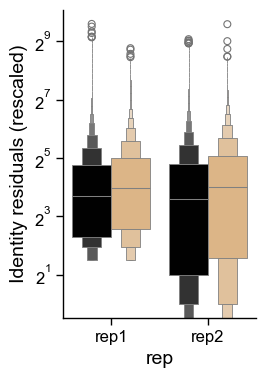

In [9]:
fig, ax= plt.subplots(figsize=(2.5,4))
sns.boxenplot(data=screen.filtered_umi_df, y="identity_resid_rescaled", x="rep", hue="control", palette=['#010101', '#EAB679'], linecolor="grey", width=0.8, 
              rasterized=True, legend=False,
              ax=ax)
plt.yscale("log", base=2)
ax.set_ylabel("Identity residuals (rescaled)")
sns.despine()
# fig.savefig("initial_screen_identity_residuals.svg", bbox_inches="tight")

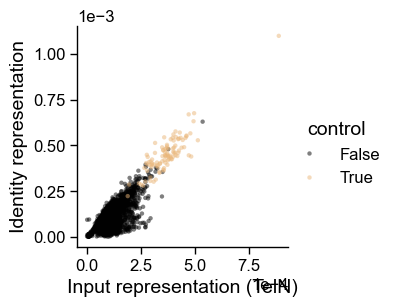

In [10]:
fig = sns.relplot(data=screen.summary_df.sort_values("control"), x="TelN_repr", y="identity_screen_rep", hue="control", palette=['#010101', '#EAB679'],
            s=10, linewidth=0, alpha=0.5, height=3, aspect=1.15, rasterized=True)
# plt.xlim(None, 0.0007)
# plt.ylim(None, 0.0007)
plt.xlabel("Input representation (TelN)")
plt.ylabel("Identity representation")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
# fig.savefig("identity_vs_input_repr.svg", bbox_inches="tight")

In [11]:
screen.summary_df["protospacer"] = screen.summary_df.guide_identity.str.split("_").str[-1]
screen.summary_df["depletion"] = screen.summary_df.identity_log2fc - screen.summary_df.query("control").identity_log2fc.mean()

(-6.850806382249893, 2.5)

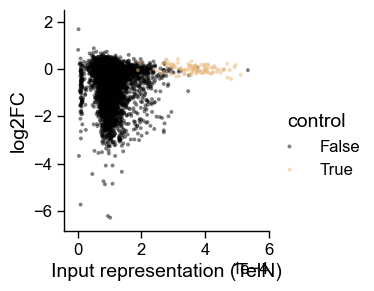

In [12]:
fig = sns.relplot(data=screen.summary_df, x="TelN_repr", y="depletion", hue="control", palette=['#010101', '#EAB679'],
            s=8, linewidth=0, alpha=0.5, height=3, aspect=1, rasterized=True)
plt.xlim(None, 0.0006)
plt.xlabel("Input representation (TelN)")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.ylabel("log2FC")
plt.ylim(None, 2.5)
# fig.savefig("log2fc_depletion.svg", bbox_inches="tight")

### Comparing to fitness phenotype

In [13]:
CRISPRi_guide_fitness = pd.read_excel("../elife-19760-supp7-v2.xlsx", skiprows=1, index_col=0)
id_protospacer = pd.read_excel("../elife-19760-supp3-v2.xlsx", sheet_name='hCRISPRi-v2', skiprows=np.arange(1,9), index_col=0)

CRISPRi_guide_fitness = CRISPRi_guide_fitness.merge(id_protospacer[["protospacer sequence"]], left_index=True, right_index=True)
CRISPRi_guide_fitness.index.name = "transcript"

In [14]:
merged_df = screen.summary_df.merge(CRISPRi_guide_fitness.reset_index(), left_on="protospacer", right_on="protospacer sequence")

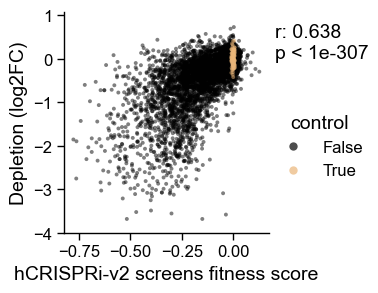

In [15]:
x = "gamma, ave_Rep1_Rep2"
y = "depletion"
g = sns.relplot(data=merged_df.sort_values("control"), x=x, y=y,
                    hue="control", s=8, linewidth=0, alpha=0.5, palette=['#010101', '#EAB679'], rasterized=True, height=3)
r, p = pearsonr(merged_df.replace([np.inf, -np.inf], np.nan)[[x, y]].dropna()[y],
                             merged_df.replace([np.inf, -np.inf], np.nan)[[x, y]].dropna()[x])

n = len(merged_df.replace([np.inf, -np.inf], np.nan)[[x, y]].dropna()[x])

# Compute the t-statistic for the correlation
t_stat = r * np.sqrt((n - 2) / (1 - r**2))
dgf = n - 2  # Degrees of freedom

# Calculate log of two-tailed p-value
try:
    log_p = np.log(2) + t.logsf(np.abs(t_stat), dgf)
except FloatingPointError:
    log_p = -np.inf  # Handle underflow

# Get the smallest representable positive float in base-10
min_float = np.finfo(float).tiny 
log10_min = np.log10(min_float)
exponent = int(np.floor(log10_min) + 1)

# Handle cases where p-value is smaller than min_float
if np.isneginf(log_p) or (log_p / np.log(10) < log10_min):
    p_bound = f"1e{exponent}" 
else:
    log10_p = log_p / np.log(10)
    exponent = int(np.floor(log10_p) + 1)
    p_bound = f"1e{exponent}"

text = f"r: {r:.3f}\np < {p_bound}"
g.ax.text(1.03, 0.95, text, transform=g.ax.transAxes, fontsize=14, verticalalignment='top')
g.set(ylim=(-4, None))
plt.xlabel("hCRISPRi-v2 screens fitness score")
plt.ylabel("Depletion (log2FC)")
for lh in g.legend.legend_handles:
    lh.set_markersize(6)
    lh.set_alpha(0.7)

# plt.savefig("depletion_logFC_fitness.svg", bbox_inches='tight', transparent=True, pad_inches=0.1)

### Comparison between replicates

In [16]:
umi_df = pd.read_csv(umi_filepath)

In [17]:
screen_rep1 = PORTAL(umi_df.query("rep == 'rep1'"), input_rep_data=TelN_rep_filepath,
                      rep_guide_columns=["guide_identity"],
                      sample_columns=["rep"])
screen_rep2 = PORTAL(umi_df.query("rep == 'rep2'"), input_rep_data=TelN_rep_filepath,
                      rep_guide_columns=["guide_identity"],
                      sample_columns=["rep"])
screen_rep1.run_standard_analysis()
screen_rep2.run_standard_analysis()

Generated guide IDs: 2390 genes with 9355 guides
Generated guide IDs: 2390 genes with 9355 guides
Step 1/7: Filtering overrepresented lineages...
Applied thresholds: repr1=0.0500, repr2=0.0500
Step 2/7: Setting controls...
Step 3/7: Log transforming UMIs...
Step 4/7: Formatting sample columns...
Step 5/7: Regressing reporter...
Coefficients: [[0.19643946 0.        ]]
Intercept: [2.69262382]
R^2 score: 0.26454630477571395
Step 6/7: Regressing identity (Poisson)...
Step 7/7: Calculating summary statistics...

Analysis complete!
Summary: 9353 guides
  Controls: 100
  Targeting: 9253
Step 1/7: Filtering overrepresented lineages...
Applied thresholds: repr1=0.0500, repr2=0.0500
Step 2/7: Setting controls...
Step 3/7: Log transforming UMIs...
Step 4/7: Formatting sample columns...
Step 5/7: Regressing reporter...
Coefficients: [[0.39007791 0.        ]]
Intercept: [2.06856202]
R^2 score: 0.3968505446717464
Step 6/7: Regressing identity (Poisson)...
Step 7/7: Calculating summary statistics...


In [18]:
screen_rep1.filtered_umi_df["ensembl"] = screen_rep1.filtered_umi_df.guide_identity.str.split("_").str[0]
screen_rep2.filtered_umi_df["ensembl"] = screen_rep2.filtered_umi_df.guide_identity.str.split("_").str[0]
screen_rep1.filtered_umi_df['gene_name'] = screen_rep1.filtered_umi_df['ensembl'].map(map_ensembl_symbol)
screen_rep2.filtered_umi_df['gene_name'] = screen_rep2.filtered_umi_df['ensembl'].map(map_ensembl_symbol)

In [19]:
rep1_results_df = run_mwu_analysis(
    pert_df=screen_rep1.filtered_umi_df,
    control_df=screen_rep1.filtered_umi_df.query("control"),
    group_cols=['gene_name', 'protospacer_mapped'],
    outcomes=['reporter_resid', 'log2_identity_rescaled']
)

Preparing perturbation and control groups...
Processing 9353 perturbations against 100 control groups...


Processing perturbations: 100%|███████████████| 9353/9353 [00:43<00:00, 213.08it/s]


Computing median statistics...
Applying FDR correction...


In [20]:
rep2_results_df = run_mwu_analysis(
    pert_df=screen_rep2.filtered_umi_df,
    control_df=screen_rep2.filtered_umi_df.query("control"),
    group_cols=['gene_name', 'protospacer_mapped'],
    outcomes=['reporter_resid', 'log2_identity_rescaled']
)

Preparing perturbation and control groups...
Processing 9354 perturbations against 100 control groups...


Processing perturbations: 100%|███████████████| 9354/9354 [00:41<00:00, 225.51it/s]


Computing median statistics...
Applying FDR correction...


In [21]:
rep1_wide_df = rep1_results_df.pivot_table(
    index='perturbation',
    columns='outcome',
    values=['rbc', 'p_adj'],
    aggfunc='first'
)
rep1_wide_df.columns = [f'{col[0]}_{col[1]}' for col in rep1_wide_df.columns]
rep1_wide_df = rep1_wide_df.reset_index()

rep2_wide_df = rep2_results_df.pivot_table(
    index='perturbation',
    columns='outcome',
    values=['rbc', 'p_adj'],
    aggfunc='first'
)
rep2_wide_df.columns = [f'{col[0]}_{col[1]}' for col in rep2_wide_df.columns]
rep2_wide_df = rep2_wide_df.reset_index()

In [22]:
rep1_wide_df['gene'] = rep1_wide_df['perturbation'].apply(lambda x: x[0])
rep1_wide_df['protospacer'] = rep1_wide_df['perturbation'].apply(lambda x: x[1])
rep2_wide_df['gene'] = rep2_wide_df['perturbation'].apply(lambda x: x[0])
rep2_wide_df['protospacer'] = rep2_wide_df['perturbation'].apply(lambda x: x[1])

In [23]:
rep1_wide_df["control"] = rep1_wide_df['gene'] == 'non-targeting'
rep2_wide_df["control"] = rep2_wide_df['gene'] == 'non-targeting'

In [24]:
summary_df = pd.merge(rep1_wide_df, rep2_wide_df,
                      on=["perturbation", "gene", "protospacer", "control"],
                      suffixes=("_rep1", "_rep2"))

Text(0, 0.5, 'reporter MW effect size replicate 2')

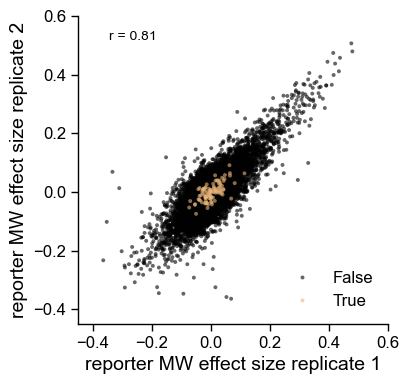

In [25]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(summary_df,
            x="rbc_reporter_resid_rep1",
            y="rbc_reporter_resid_rep2", s=8, linewidth=0, alpha=0.6,
                hue="control", palette=['#010101', '#EAB679'], rasterized=True)
r = summary_df[["rbc_reporter_resid_rep1", "rbc_reporter_resid_rep2"]].corr().iloc[0,1]
plt.text(0.1, 0.95, f'r = {r:.2f}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')
sns.despine()
plt.legend(frameon=False)
plt.xlim(-0.45, 0.6)
plt.ylim(-0.45, 0.6)
plt.xlabel("reporter MW effect size replicate 1")
plt.ylabel("reporter MW effect size replicate 2")
# fig.savefig("figure_screen_reporter_replicates_RBC.svg", bbox_inches="tight")

Text(0, 0.5, 'identity MW effect size replicate 2')

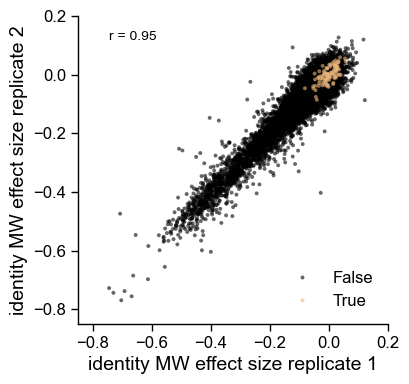

In [26]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(summary_df,
            x="rbc_log2_identity_rescaled_rep1",
            y="rbc_log2_identity_rescaled_rep2", s=8, linewidth=0, alpha=0.6,
                hue="control", palette=['#010101', '#EAB679'], rasterized=True)
r = summary_df[["rbc_log2_identity_rescaled_rep1", "rbc_log2_identity_rescaled_rep2"]].corr().iloc[0,1]
plt.text(0.1, 0.95, f'r = {r:.2f}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')
sns.despine()
plt.legend(frameon=False)
plt.xlim(-0.85, 0.2)
plt.ylim(-0.85, 0.2)
plt.xlabel("identity MW effect size replicate 1")
plt.ylabel("identity MW effect size replicate 2")
# fig.savefig("figure_screen_identity_replicates_RBC.svg", bbox_inches="tight")

### Mann–Whitney U tests and visualizations

In [27]:
screen.filtered_umi_df["ensembl"] = screen.filtered_umi_df.guide_identity.str.split("_").str[0]
screen.filtered_umi_df['gene_name'] = screen.filtered_umi_df['ensembl'].map(map_ensembl_symbol)
screen.umi_df['gene_name'] = screen.umi_df['ensembl'].map(map_ensembl_symbol)

In [28]:
results_df = run_mwu_analysis(
    pert_df=screen.filtered_umi_df,
    control_df=screen.filtered_umi_df.query("control"),
    group_cols=['gene_name', 'protospacer_mapped'],
    outcomes=['reporter_resid', 'log2_identity_rescaled']
)

Preparing perturbation and control groups...
Processing 9354 perturbations against 100 control groups...


Processing perturbations: 100%|███████████████| 9354/9354 [01:30<00:00, 103.28it/s]


Computing median statistics...
Applying FDR correction...


9 [-0.39869135  0.19354523]
106 [0.20977625 0.97500406]
0 [-0.28076311 -0.39676172]
88 [-0.58332285  0.12205881]


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


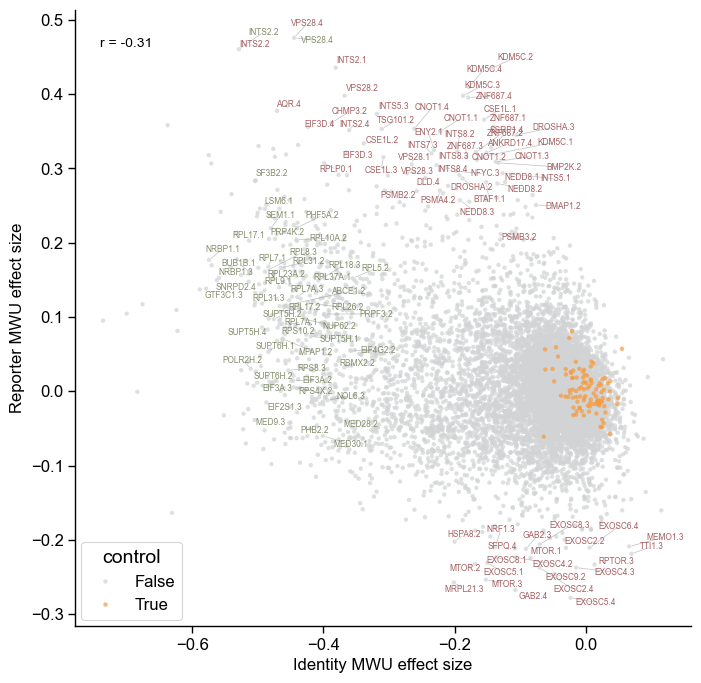

In [29]:
wide_df = results_df.pivot_table(
    index='perturbation',
    columns='outcome',
    values=['rbc', 'p_adj'],
    aggfunc='first'
)

wide_df.columns = [f'{col[0]}_{col[1]}' for col in wide_df.columns]
wide_df = wide_df.reset_index()

wide_df['gene'] = wide_df['perturbation'].apply(lambda x: x[0])
wide_df["id"] = wide_df.groupby('gene').cumcount() + 1
wide_df["guide_id"] = wide_df["gene"] + "." + wide_df["id"].astype(str)

wide_df['-log10_p_adj_reporter'] = -np.log10(wide_df['p_adj_reporter_resid'])
wide_df['-log10_p_adj_identity'] = -np.log10(wide_df['p_adj_log2_identity_rescaled'])
wide_df['-log10_p_combined'] = wide_df[['-log10_p_adj_reporter','-log10_p_adj_identity']].sum(axis=1)
wide_df["control"] = wide_df['gene'] == 'non-targeting'

annotate_df1 = (wide_df[wide_df['rbc_reporter_resid'] > 0.2]
                .nlargest(50, '-log10_p_adj_reporter')
                .copy())
annotate_df2 = (wide_df[wide_df['rbc_reporter_resid'] < -0.2]
                .nlargest(50, '-log10_p_adj_reporter')
                .copy())
annotate_df3 = (wide_df[wide_df['rbc_log2_identity_rescaled'] < -0.2]
                .nlargest(50, '-log10_p_adj_identity')
                .copy())

colors = ['#D1D3D4', '#f8993a']
palette = sns.color_palette(colors)
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(
    data=wide_df,
    x='rbc_log2_identity_rescaled',
    y='rbc_reporter_resid',
    s=10,
    alpha=0.7,
    hue="control",
    linewidth=0,
    palette=palette,
    rasterized=False
)
ax.set_box_aspect(1)

texts = []
for _, row in annotate_df1.iterrows():
    texts.append(plt.text(
        x=row['rbc_log2_identity_rescaled'],
        y=row['rbc_reporter_resid'],
        s=row['guide_id'],
        fontsize=6,
        color="#a75f61"
    ))

for _, row in annotate_df2.iterrows():
    texts.append(plt.text(
        x=row['rbc_log2_identity_rescaled'],
        y=row['rbc_reporter_resid'],
        s=row['guide_id'],
        fontsize=6,
        color="#a75f61"
    ))

for _, row in annotate_df3.iterrows():
    texts.append(plt.text(
        x=row['rbc_log2_identity_rescaled'],
        y=row['rbc_reporter_resid'],
        s=row['guide_id'],
        fontsize=6,
        color="#848e6c"
    ))

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.5),
    expand_points=(1., 1.),
    expand_text=(1., 1.),
    ax=ax
)

plt.xlabel('Identity MWU effect size', fontsize=12)
plt.ylabel('Reporter MWU effect size', fontsize=12)

corr = np.corrcoef(
    wide_df['rbc_reporter_resid'].dropna(),
    wide_df['rbc_log2_identity_rescaled'].dropna()
)[0, 1]
plt.text(
    0.04, 0.94,
    f'r = {corr:.2f}',
    transform=ax.transAxes,
    fontsize=10,
)

plt.legend(bbox_to_anchor=(0.01, 0.01), loc='lower left', borderaxespad=0., title="control")
sns.despine()

# plt.savefig("essentials_screen_identity_reporter_scatter.svg")

In [30]:
wide_df["protospacer"] = wide_df.perturbation.str[1]
phenotype_df = wide_df[["protospacer", "gene", "guide_id",
                        "rbc_reporter_resid", "p_adj_reporter_resid", 
                        "rbc_log2_identity_rescaled", "p_adj_log2_identity_rescaled"
                       ]].copy()

phenotype_df = phenotype_df.rename(
    columns={"rbc_reporter_resid": "rbc_reporter",
             "p_adj_reporter_resid": "p_adj_reporter",
             "rbc_log2_identity_rescaled": "rbc_identity",
             "p_adj_log2_identity_rescaled": "p_adj_identity"})

In [31]:
# phenotype_df.to_csv("pilot_screen_guide_level_phenotypes.csv", index=False, float_format='%g')

(-1.5, 3.0)

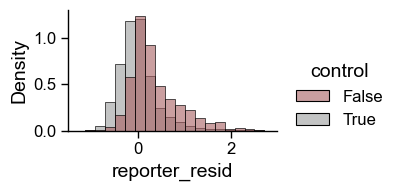

In [32]:
guide = 'KDM5C.2'
p = wide_df[wide_df.guide_id == guide].perturbation.values[0][1]
fig = sns.displot(data=screen.filtered_umi_df.query("(protospacer_mapped == @p) or control"),
            x="reporter_resid", hue="control", palette=["#a75f61", "#9B9D9D"],
            common_norm=False, stat="density", bins=30, height=2, aspect=1.5, alpha=0.6)
plt.xlim(-1.5, 3)

(-1.5, 3.0)

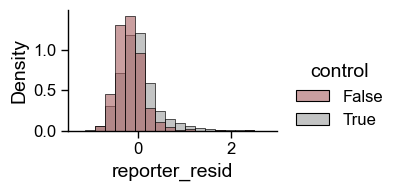

In [33]:
guide = 'GAB2.4'
p = wide_df[wide_df.guide_id == guide].perturbation.values[0][1]
fig = sns.displot(data=screen.filtered_umi_df.query("(protospacer_mapped == @p) or control"),
            x="reporter_resid", hue="control", palette=["#a75f61", "#9B9D9D"],
            common_norm=False, stat="density", bins=30, height=2, aspect=1.5, alpha=0.6)
plt.xlim(-1.5, 3)

Text(0.5, 8.84444444444445, 'log2_identity')

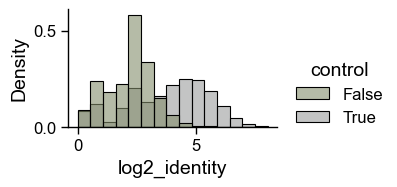

In [34]:
guide = 'NRBP1.3'
p = wide_df[wide_df.guide_id == guide].perturbation.values[0][1]
fig = sns.displot(data=screen.filtered_umi_df.query("(protospacer_mapped == @p) or control"),
            x="log2_identity_rescaled", hue="control", palette=["#848e6c", "#9B9D9D"],
            common_norm=False, stat="density", bins=15, height=2, aspect=1.5, binrange=(0,8), alpha=0.6)
plt.yticks([0,0.5])
plt.xticks([0,5])
plt.xlabel("log2_identity")

### Correlation with Perturb-seq profiles and GSEA

In [35]:
from perturbseq import *

In [36]:
protospacers = screen.filtered_umi_df.protospacer_mapped.unique()
mean_reporter_activity = screen.filtered_umi_df.groupby("protospacer_mapped").reporter_resid.mean().sort_values()

In [37]:
k562_mean_pop = CellPopulation.from_hdf(genomewide_perturbseq_path,
                             stored_matrix_ids = set(['gemgroup']))

Loading matrix...
Loading metadata...
Done in 0.4565129280090332s.
Done.


In [38]:
select_pop = k562_mean_pop.subpopulation(cells="protospacer_A in @protospacers and protospacer_B in @protospacers",
                            normalized_matrix='inherit', protospacers=protospacers, calculate_statistics=False)

Done.
Inheriting from parent multiple normalized matrices...


In [39]:
select_pop.cells["reporter_activity_protospacer_A"] = mean_reporter_activity.loc[select_pop.cells.protospacer_A].values
select_pop.cells["reporter_activity_protospacer_B"] = mean_reporter_activity.loc[select_pop.cells.protospacer_B].values
select_pop.genes["corr_A"] = select_pop.normalized_matrix["gemgroup"].corrwith(select_pop.cells.reporter_activity_protospacer_A, method="pearson")
select_pop.genes["corr_B"] = select_pop.normalized_matrix["gemgroup"].corrwith(select_pop.cells.reporter_activity_protospacer_B, method="pearson")
select_pop.genes["mean_corr"] = (select_pop.genes["corr_A"] + select_pop.genes["corr_B"])/2

In [40]:
rnk = select_pop.genes.sort_values("mean_corr", ascending=False).reset_index().set_index("gene_name")[["mean_corr"]].copy()

In [41]:
pre_res_TF = gp.prerank(rnk=rnk,
                     gene_sets='../c3.tft.tft_legacy.v2024.1.Hs.symbols.gmt',
                     threads=16,
                     min_size=100,
                     max_size=500,
                     permutation_num=100000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=0,
                     verbose=True,
                    )

2026-01-12 17:21:47,912 [INFO] Input gene rankings contains duplicated IDs
2026-01-12 17:21:47,917 [INFO] Parsing data files for GSEA.............................
2026-01-12 17:21:47,984 [INFO] 0308 gene_sets have been filtered out when max_size=500 and min_size=100
2026-01-12 17:21:47,985 [INFO] 0302 gene_sets used for further statistical testing.....
2026-01-12 17:21:47,985 [INFO] Start to run GSEA...Might take a while..................
2026-01-12 17:24:55,722 [INFO] Congratulations. GSEApy runs successfully................



In [42]:
sig_res_TF_pos = pre_res_TF.res2d.query("`FWER p-val` < 0.05").sort_values(["NES"], ascending=False).query("NES > 0").reset_index()

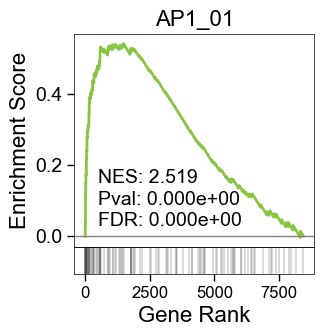

In [43]:
term_data = pre_res_TF.results[sig_res_TF_pos.iloc[0].Term]

g = custom_gseaplot( figsize=(3,3),
         term="AP1_01", #ofname="AP1_01_gsea.svg",
         pre_res=pre_res_TF)
plt.show()

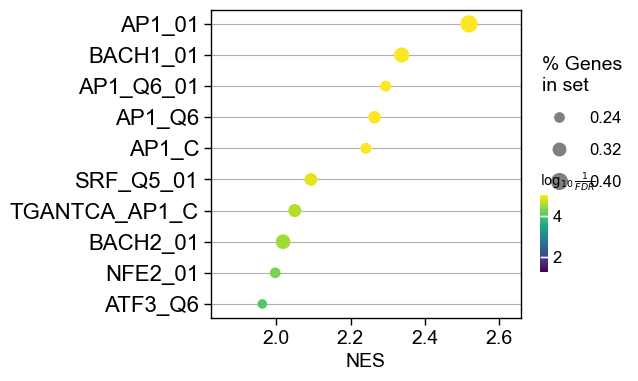

In [44]:
ax = dotplot(sig_res_TF_pos.sort_values("NES"),
             column="FDR q-val",
             cmap=plt.cm.viridis,
             # ofname="GSEA_dotplot.svg",
             size=6, top_term=10,
             figsize=(5,4), cutoff=0.05, show_ring=False)